In [3]:
# === LOAD DATA AND MODEL ===
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load datasets
train = pd.read_csv('../data/processed/train_data.csv')
val = pd.read_csv('../data/processed/val_data.csv')
test = pd.read_csv('../data/processed/test_data.csv')

# Create encoding maps
material_price_map = train.groupby('Material_Clean')['Unit_Price'].mean().to_dict()
group_price_map = train.groupby('Material Group')['Unit_Price'].mean().to_dict()

# Encode features
for df in [train, val, test]:
    df['Material_Enc'] = df['Material_Clean'].map(material_price_map).fillna(train['Unit_Price'].mean())
    df['Group_Enc'] = df['Material Group'].map(group_price_map).fillna(train['Unit_Price'].mean())

# Train model
X_train = train[['Material_Enc', 'Group_Enc', 'Order Quantity', 'Unit_Cost']]
y_train = train['Unit_Price']
X_test = test[['Material_Enc', 'Group_Enc', 'Order Quantity', 'Unit_Cost']]
y_test = test['Unit_Price']

model = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Add predictions and metrics
test['Predicted_Price'] = model.predict(X_test)
test['Current_Margin'] = ((test['Unit_Price'] - test['Unit_Cost']) / test['Unit_Price'] * 100)
test['Predicted_Margin'] = ((test['Predicted_Price'] - test['Unit_Cost']) / test['Predicted_Price'] * 100)
test['Price_Change_%'] = ((test['Predicted_Price'] - test['Unit_Price']) / test['Unit_Price'] * 100)
test['Revenue_Impact'] = (test['Predicted_Price'] - test['Unit_Price']) * test['Order Quantity']

# Calculate key metrics
current_revenue = (test['Unit_Price'] * test['Order Quantity']).sum()
optimized_revenue = (test['Predicted_Price'] * test['Order Quantity']).sum()
opportunity = optimized_revenue - current_revenue
underpriced = test[test['Price_Change_%'] > 5]
overpriced = test[test['Price_Change_%'] < -5]
quantities = [50, 100, 200, 500, 1000, 2000]

print("✓ Data loaded and model trained")
print(f"✓ Test R²: {r2_score(y_test, test['Predicted_Price']):.3f}")
print(f"✓ Revenue Opportunity: ₹{opportunity:,.0f}")


✓ Data loaded and model trained
✓ Test R²: 0.652
✓ Revenue Opportunity: ₹56,772,596


In [4]:
def get_price_recommendation(material, quantity, cost):
    """Interactive price recommendation"""
    mat_enc = material_price_map.get(material, train['Unit_Price'].mean())
    group = test[test['Material_Clean']==material]['Material Group'].iloc[0] if material in test['Material_Clean'].values else 'B0003'
    group_enc = group_price_map.get(group, train['Unit_Price'].mean())
    
    input_data = pd.DataFrame([[mat_enc, group_enc, quantity, cost]], 
                              columns=['Material_Enc', 'Group_Enc', 'Order Quantity', 'Unit_Cost'])
    predicted_price = model.predict(input_data)[0]
    margin = ((predicted_price - cost) / predicted_price) * 100
    
    return predicted_price, margin

# Demo: Price Recommendations
print("="*70)
print("A. PRICE RECOMMENDATION SYSTEM")
print("="*70)
sample_materials = test.groupby('Material_Clean').size().sort_values(ascending=False).head(3).index
for mat in sample_materials:
    sample = test[test['Material_Clean']==mat].iloc[0]
    pred_price, pred_margin = get_price_recommendation(mat, sample['Order Quantity'], sample['Unit_Cost'])
    print(f"\n📦 Material: {mat}")
    print(f"   Input:  Quantity={sample['Order Quantity']:.0f}, Cost=₹{sample['Unit_Cost']:.2f}")
    print(f"   Current Price:     ₹{sample['Unit_Price']:.2f} ({sample['Current_Margin']:.1f}% margin)")
    print(f"   Recommended Price: ₹{pred_price:.2f} ({pred_margin:.1f}% margin)")
    print(f"   Change: {((pred_price-sample['Unit_Price'])/sample['Unit_Price']*100):+.1f}%")

A. PRICE RECOMMENDATION SYSTEM

📦 Material: 200300013300
   Input:  Quantity=235, Cost=₹5307.92
   Current Price:     ₹5478.00 (3.1% margin)
   Recommended Price: ₹5919.32 (10.3% margin)
   Change: +8.1%

📦 Material: 200300013350
   Input:  Quantity=448, Cost=₹5307.92
   Current Price:     ₹6197.50 (14.4% margin)
   Recommended Price: ₹6098.15 (13.0% margin)
   Change: -1.6%

📦 Material: 200300013250
   Input:  Quantity=188, Cost=₹5228.05
   Current Price:     ₹5573.75 (6.2% margin)
   Recommended Price: ₹6048.57 (13.6% margin)
   Change: +8.5%


In [5]:
# B. PROFIT IMPACT ANALYSIS
print("\n" + "="*70)
print("B. PROFIT IMPACT ANALYSIS")
print("="*70)
current_revenue = (test['Unit_Price'] * test['Order Quantity']).sum()
optimized_revenue = (test['Predicted_Price'] * test['Order Quantity']).sum()
opportunity = optimized_revenue - current_revenue

print(f"\n💰 Revenue Analysis:")
print(f"   Current Revenue:    ₹{current_revenue:,.0f}")
print(f"   Optimized Revenue:  ₹{optimized_revenue:,.0f}")
print(f"   Opportunity:        ₹{opportunity:,.0f} ({opportunity/current_revenue*100:+.2f}%)")

print(f"\n📊 Material-Level Opportunities:")
top_opps = test.groupby('Material_Clean').agg({
    'Revenue_Impact': 'sum',
    'Price_Change_%': 'mean',
    'Material_Clean': 'count'
}).rename(columns={'Material_Clean': 'Transactions'}).sort_values('Revenue_Impact', ascending=False).head(5)
print(top_opps.to_string())


B. PROFIT IMPACT ANALYSIS

💰 Revenue Analysis:
   Current Revenue:    ₹12,160,006,551
   Optimized Revenue:  ₹12,216,779,147
   Opportunity:        ₹56,772,596 (+0.47%)

📊 Material-Level Opportunities:
                Revenue_Impact  Price_Change_%  Transactions
Material_Clean                                              
200300053300      7.640752e+07        4.498035            30
200100013450      3.472502e+05        5.118546            12
200100023500      6.229183e+04       21.187663             1
200200170400      2.290874e+04       23.863273             1
200201033450      1.844103e+04        2.977996             2


In [6]:
# C. VOLUME-BASED PRICING
print("\n" + "="*70)
print("C. VOLUME-BASED PRICING ANALYSIS")
print("="*70)
sample_mat = test['Material_Clean'].mode()[0]
sample_cost = test[test['Material_Clean']==sample_mat]['Unit_Cost'].mean()
quantities = [50, 100, 200, 500, 1000, 2000]
prices = []
for qty in quantities:
    price, _ = get_price_recommendation(sample_mat, qty, sample_cost)
    prices.append(price)
    
print(f"\n📦 Material: {sample_mat} (Cost: ₹{sample_cost:.2f})")
print(f"{'Quantity':<12} {'Price':<12} {'Discount %'}")
print("-" * 40)
for qty, price in zip(quantities, prices):
    discount = ((prices[0] - price) / prices[0]) * 100
    print(f"{qty:<12} ₹{price:<11.2f} {discount:>6.1f}%")


C. VOLUME-BASED PRICING ANALYSIS

📦 Material: 200300013300 (Cost: ₹5303.04)
Quantity     Price        Discount %
----------------------------------------
50           ₹6179.46        0.0%
100          ₹7566.55      -22.4%
200          ₹5981.07        3.2%
500          ₹6778.22       -9.7%
1000         ₹7522.17      -21.7%
2000         ₹5892.62        4.6%


In [7]:
# D. MODEL PERFORMANCE SUMMARY
print("\n" + "="*70)
print("D. MODEL PERFORMANCE METRICS")
print("="*70)
print(f"\n📈 Accuracy Metrics:")
print(f"   R² Score:           {r2_score(y_test, test['Predicted_Price']):.3f}")
print(f"   Mean Absolute Error: ₹{mean_absolute_error(y_test, test['Predicted_Price']):.2f}")
print(f"   RMSE:               ₹{np.sqrt(mean_squared_error(y_test, test['Predicted_Price'])):.2f}")
print(f"   MAPE:               {(abs((test['Unit_Price']-test['Predicted_Price'])/test['Unit_Price']).mean()*100):.2f}%")

print(f"\n🎯 Feature Importance:")
for feat, imp in zip(['Unit Cost', 'Order Quantity', 'Material', 'Group'], model.feature_importances_):
    print(f"   {feat:<20} {'█' * int(imp*50)} {imp:.3f}")
    


D. MODEL PERFORMANCE METRICS

📈 Accuracy Metrics:
   R² Score:           0.652
   Mean Absolute Error: ₹320.89
   RMSE:               ₹1000.85
   MAPE:               4.97%

🎯 Feature Importance:
   Unit Cost             0.007
   Order Quantity        0.000
   Material             ████ 0.098
   Group                ████████████████████████████████████████████ 0.895


In [8]:
# E. BUSINESS INSIGHTS
print("\n" + "="*70)
print("E. BUSINESS INSIGHTS")
print("="*70)

underpriced = test[test['Price_Change_%'] > 5]
overpriced = test[test['Price_Change_%'] < -5]
print(f"\n💡 Pricing Opportunities:")
print(f"   Underpriced transactions: {len(underpriced)} ({len(underpriced)/len(test)*100:.1f}%)")
print(f"   Overpriced transactions:  {len(overpriced)} ({len(overpriced)/len(test)*100:.1f}%)")
print(f"   Optimally priced:         {len(test)-len(underpriced)-len(overpriced)} ({(len(test)-len(underpriced)-len(overpriced))/len(test)*100:.1f}%)")

print(f"\n🏆 Top 5 Underpriced Materials (Increase Price):")
underpriced_mats = test[test['Price_Change_%']>0].groupby('Material_Clean').agg({
    'Price_Change_%': 'mean',
    'Revenue_Impact': 'sum'
}).sort_values('Revenue_Impact', ascending=False).head(5)
print(underpriced_mats.to_string())

print("\n" + "="*70)


E. BUSINESS INSIGHTS

💡 Pricing Opportunities:
   Underpriced transactions: 251 (12.0%)
   Overpriced transactions:  102 (4.9%)
   Optimally priced:         1747 (83.2%)

🏆 Top 5 Underpriced Materials (Increase Price):
                Price_Change_%  Revenue_Impact
Material_Clean                                
200300013300          3.336469    8.696341e+07
200300053300         11.670019    7.815906e+07
200300013250          7.988643    3.902111e+07
202038003300          2.626275    1.003743e+07
200300013350          0.407778    1.903451e+06



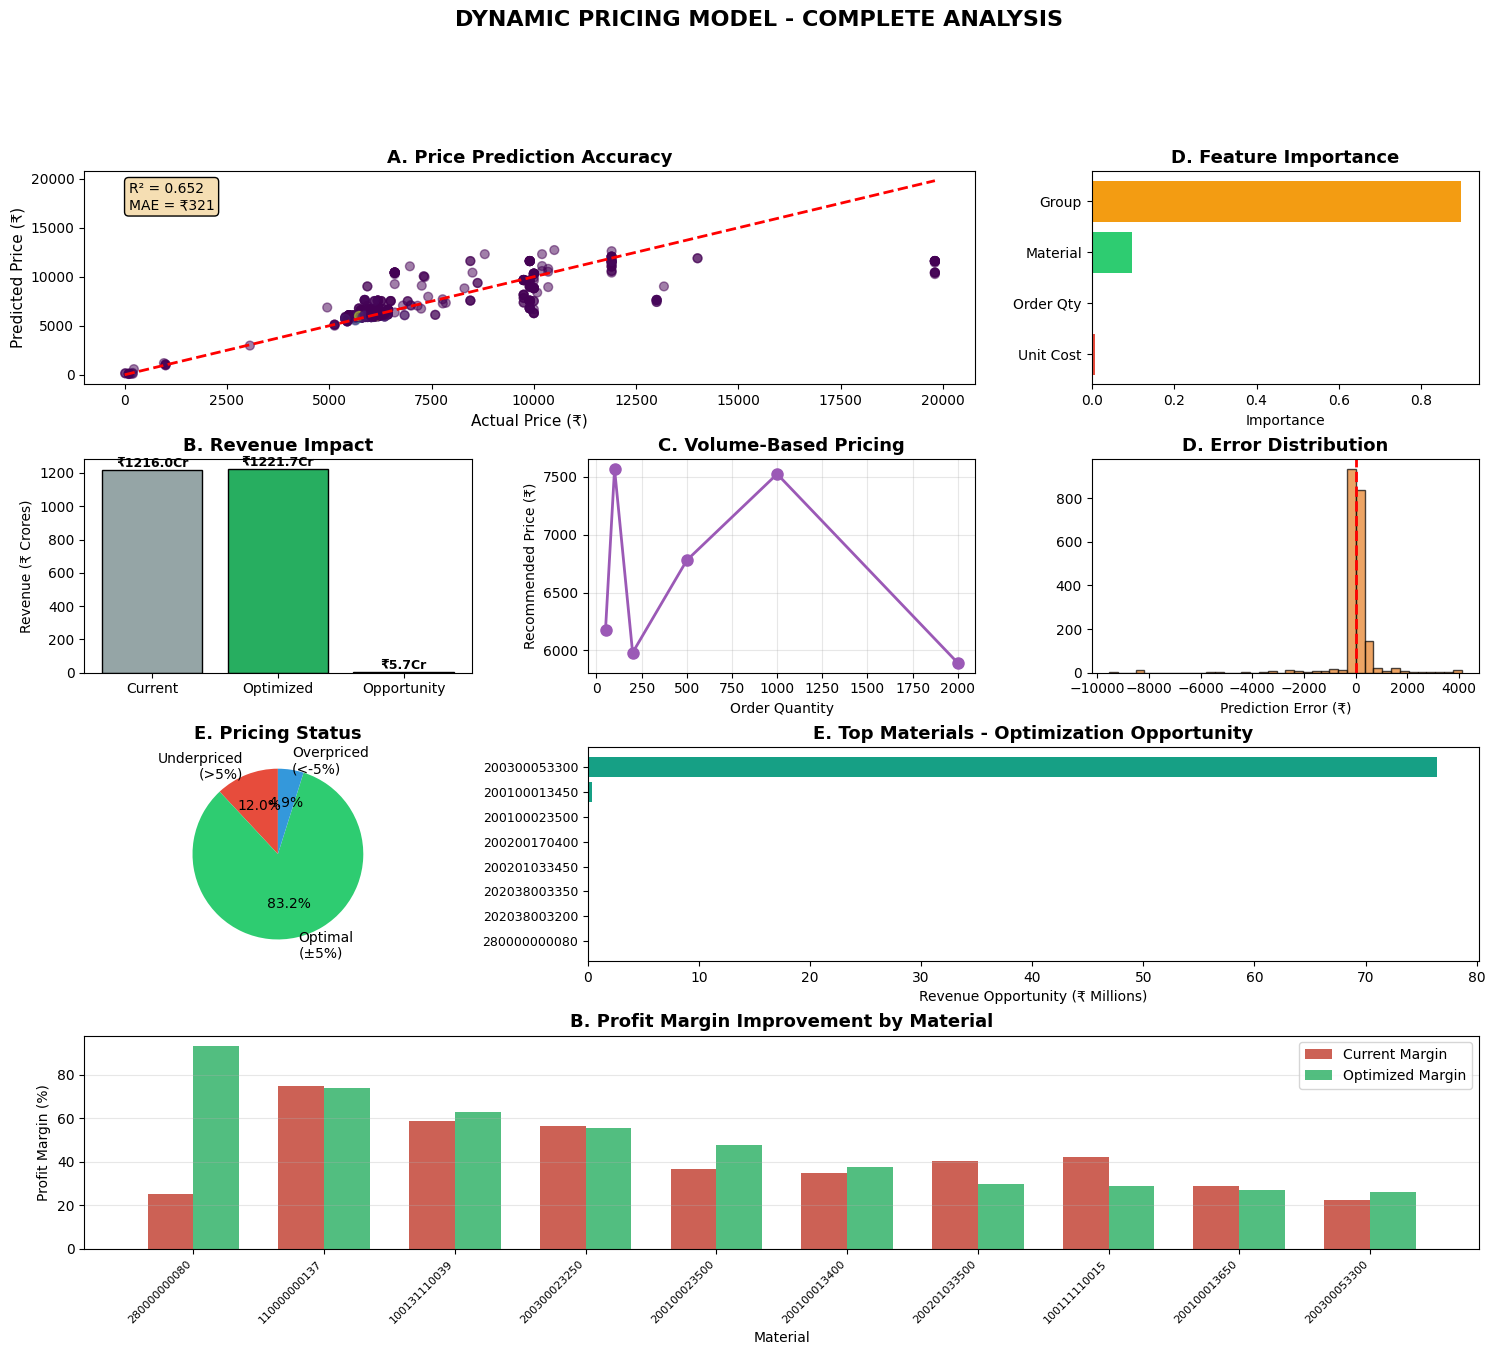


✓ Complete analysis saved: complete_pricing_analysis.png


In [10]:
# === COMPREHENSIVE VISUALIZATION SUITE ===
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18, 14))
gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.3)

# 1. Actual vs Predicted
ax1 = fig.add_subplot(gs[0, :2])
ax1.scatter(test['Unit_Price'], test['Predicted_Price'], alpha=0.5, s=40, c=test['Order Quantity'], cmap='viridis')
ax1.plot([0, test['Unit_Price'].max()], [0, test['Unit_Price'].max()], 'r--', lw=2)
ax1.set_xlabel('Actual Price (₹)', fontsize=11)
ax1.set_ylabel('Predicted Price (₹)', fontsize=11)
ax1.set_title('A. Price Prediction Accuracy', fontsize=13, fontweight='bold')
ax1.text(0.05, 0.95, f'R² = {r2_score(y_test, test["Predicted_Price"]):.3f}\nMAE = ₹{mean_absolute_error(y_test, test["Predicted_Price"]):.0f}', 
         transform=ax1.transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat'))

# 2. Feature Importance
ax2 = fig.add_subplot(gs[0, 2])
features = ['Unit Cost', 'Order Qty', 'Material', 'Group']
ax2.barh(features, model.feature_importances_, color=['#e74c3c', '#3498db', '#2ecc71', '#f39c12'])
ax2.set_xlabel('Importance', fontsize=10)
ax2.set_title('D. Feature Importance', fontsize=13, fontweight='bold')

# 3. Revenue Impact
ax3 = fig.add_subplot(gs[1, 0])
categories = ['Current', 'Optimized', 'Opportunity']
values = [current_revenue/1e7, optimized_revenue/1e7, opportunity/1e7]
bars = ax3.bar(categories, values, color=['#95a5a6', '#27ae60', '#f1c40f'], edgecolor='black')
ax3.set_ylabel('Revenue (₹ Crores)', fontsize=10)
ax3.set_title('B. Revenue Impact', fontsize=13, fontweight='bold')
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height, f'₹{height:.1f}Cr', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 4. Volume-Based Pricing
ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(quantities, prices, marker='o', linewidth=2, markersize=8, color='#9b59b6')
ax4.set_xlabel('Order Quantity', fontsize=10)
ax4.set_ylabel('Recommended Price (₹)', fontsize=10)
ax4.set_title('C. Volume-Based Pricing', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3)

# 5. Error Distribution
ax5 = fig.add_subplot(gs[1, 2])
errors = test['Predicted_Price'] - test['Unit_Price']
ax5.hist(errors, bins=40, edgecolor='black', alpha=0.7, color='#e67e22')
ax5.axvline(0, color='red', linestyle='--', linewidth=2)
ax5.set_xlabel('Prediction Error (₹)', fontsize=10)
ax5.set_title('D. Error Distribution', fontsize=13, fontweight='bold')

# 6. Pricing Opportunities
ax6 = fig.add_subplot(gs[2, 0])
pricing_status = ['Underpriced\n(>5%)', 'Optimal\n(±5%)', 'Overpriced\n(<-5%)']
counts = [len(underpriced), len(test)-len(underpriced)-len(overpriced), len(overpriced)]
colors_pie = ['#e74c3c', '#2ecc71', '#3498db']
ax6.pie(counts, labels=pricing_status, autopct='%1.1f%%', colors=colors_pie, startangle=90)
ax6.set_title('E. Pricing Status', fontsize=13, fontweight='bold')

# 7. Top Materials by Opportunity
ax7 = fig.add_subplot(gs[2, 1:])
top_5 = test.groupby('Material_Clean')['Revenue_Impact'].sum().sort_values(ascending=False).head(8)
ax7.barh(range(len(top_5)), top_5.values/1e6, color='#16a085')
ax7.set_yticks(range(len(top_5)))
ax7.set_yticklabels(top_5.index, fontsize=9)
ax7.set_xlabel('Revenue Opportunity (₹ Millions)', fontsize=10)
ax7.set_title('E. Top Materials - Optimization Opportunity', fontsize=13, fontweight='bold')
ax7.invert_yaxis()

# 8. Margin Improvement
ax8 = fig.add_subplot(gs[3, :])
margin_comparison = test.groupby('Material_Clean').agg({
    'Current_Margin': 'mean',
    'Predicted_Margin': 'mean'
}).sort_values('Predicted_Margin', ascending=False).head(10)
x = np.arange(len(margin_comparison))
width = 0.35
ax8.bar(x - width/2, margin_comparison['Current_Margin'], width, label='Current Margin', color='#c0392b', alpha=0.8)
ax8.bar(x + width/2, margin_comparison['Predicted_Margin'], width, label='Optimized Margin', color='#27ae60', alpha=0.8)
ax8.set_xlabel('Material', fontsize=10)
ax8.set_ylabel('Profit Margin (%)', fontsize=10)
ax8.set_title('B. Profit Margin Improvement by Material', fontsize=13, fontweight='bold')
ax8.set_xticks(x)
ax8.set_xticklabels(margin_comparison.index, rotation=45, ha='right', fontsize=8)
ax8.legend()
ax8.grid(True, alpha=0.3, axis='y')

plt.suptitle('DYNAMIC PRICING MODEL - COMPLETE ANALYSIS', fontsize=16, fontweight='bold', y=0.995)
plt.savefig('../data/processed/complete_pricing_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Complete analysis saved: complete_pricing_analysis.png")


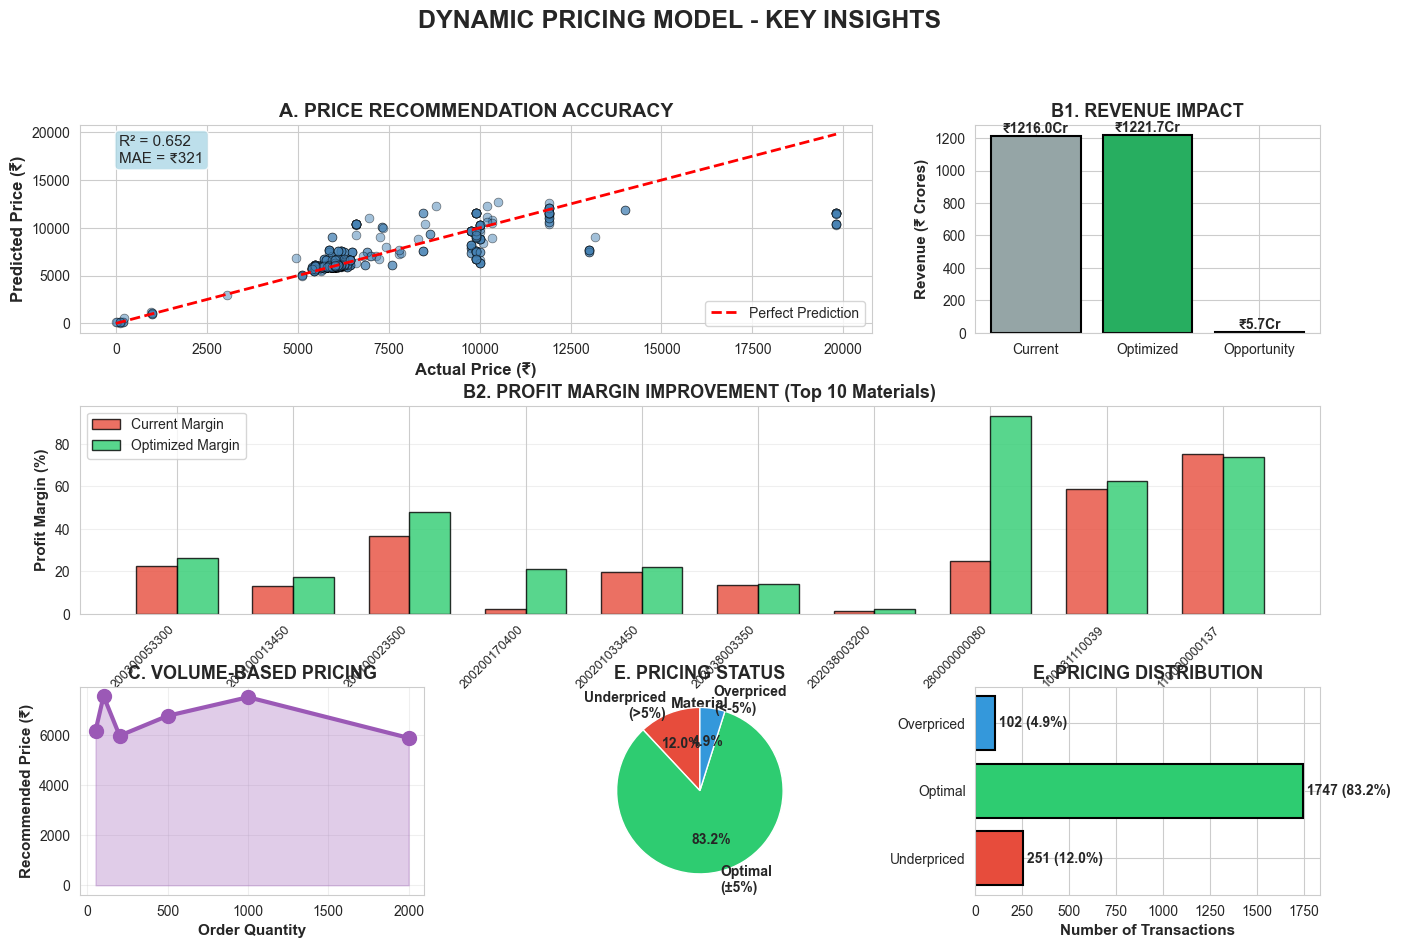


✓ Focused dashboard saved: focused_pricing_dashboard.png

📊 Summary:
   • Revenue Opportunity: ₹5.7 Crores
   • Underpriced: 251 transactions (12.0%)
   • Model Accuracy: R² = 0.652


In [11]:
# === FOCUSED PRESENTATION DASHBOARD ===
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style("whitegrid")

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# A. ACTUAL VS PREDICTED (Price Recommendations)
ax1 = fig.add_subplot(gs[0, :2])
ax1.scatter(test['Unit_Price'], test['Predicted_Price'], alpha=0.5, s=40, c='steelblue', edgecolors='black', linewidth=0.5)
ax1.plot([0, test['Unit_Price'].max()], [0, test['Unit_Price'].max()], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Price (₹)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Predicted Price (₹)', fontsize=12, fontweight='bold')
ax1.set_title('A. PRICE RECOMMENDATION ACCURACY', fontsize=14, fontweight='bold')
ax1.legend()
ax1.text(0.05, 0.95, f'R² = {r2_score(y_test, test["Predicted_Price"]):.3f}\nMAE = ₹{mean_absolute_error(y_test, test["Predicted_Price"]):.0f}', 
         transform=ax1.transAxes, fontsize=11, verticalalignment='top', 
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

# B1. REVENUE IMPACT
ax2 = fig.add_subplot(gs[0, 2])
categories = ['Current', 'Optimized', 'Opportunity']
values = [current_revenue/1e7, optimized_revenue/1e7, opportunity/1e7]
colors_rev = ['#95a5a6', '#27ae60', '#f1c40f']
bars = ax2.bar(categories, values, color=colors_rev, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Revenue (₹ Crores)', fontsize=11, fontweight='bold')
ax2.set_title('B1. REVENUE IMPACT', fontsize=13, fontweight='bold')
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'₹{height:.1f}Cr', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# B2. MARGIN IMPROVEMENT BY MATERIAL
ax3 = fig.add_subplot(gs[1, :])
margin_comparison = test.groupby('Material_Clean').agg({
    'Current_Margin': 'mean',
    'Predicted_Margin': 'mean',
    'Revenue_Impact': 'sum'
}).sort_values('Revenue_Impact', ascending=False).head(10)

x = np.arange(len(margin_comparison))
width = 0.35
bars1 = ax3.bar(x - width/2, margin_comparison['Current_Margin'], width, 
                label='Current Margin', color='#e74c3c', alpha=0.8, edgecolor='black')
bars2 = ax3.bar(x + width/2, margin_comparison['Predicted_Margin'], width, 
                label='Optimized Margin', color='#2ecc71', alpha=0.8, edgecolor='black')

ax3.set_xlabel('Material', fontsize=11, fontweight='bold')
ax3.set_ylabel('Profit Margin (%)', fontsize=11, fontweight='bold')
ax3.set_title('B2. PROFIT MARGIN IMPROVEMENT (Top 10 Materials)', fontsize=13, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(margin_comparison.index, rotation=45, ha='right', fontsize=9)
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')

# C. VOLUME-BASED PRICING
ax4 = fig.add_subplot(gs[2, 0])
sample_mat = test['Material_Clean'].mode()[0]
sample_cost = test[test['Material_Clean']==sample_mat]['Unit_Cost'].mean()
quantities = [50, 100, 200, 500, 1000, 2000]
prices = []
for qty in quantities:
    mat_enc = material_price_map.get(sample_mat, train['Unit_Price'].mean())
    group = test[test['Material_Clean']==sample_mat]['Material Group'].iloc[0]
    group_enc = group_price_map.get(group, train['Unit_Price'].mean())
    input_data = pd.DataFrame([[mat_enc, group_enc, qty, sample_cost]], 
                              columns=['Material_Enc', 'Group_Enc', 'Order Quantity', 'Unit_Cost'])
    prices.append(model.predict(input_data)[0])

ax4.plot(quantities, prices, marker='o', linewidth=3, markersize=10, color='#9b59b6')
ax4.fill_between(quantities, prices, alpha=0.3, color='#9b59b6')
ax4.set_xlabel('Order Quantity', fontsize=11, fontweight='bold')
ax4.set_ylabel('Recommended Price (₹)', fontsize=11, fontweight='bold')
ax4.set_title('C. VOLUME-BASED PRICING', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3)

# E. PRICING STATUS (Pie Chart)
ax5 = fig.add_subplot(gs[2, 1])
pricing_status = ['Underpriced\n(>5%)', 'Optimal\n(±5%)', 'Overpriced\n(<-5%)']
counts = [len(underpriced), len(test)-len(underpriced)-len(overpriced), len(overpriced)]
colors_pie = ['#e74c3c', '#2ecc71', '#3498db']
wedges, texts, autotexts = ax5.pie(counts, labels=pricing_status, autopct='%1.1f%%', 
                                     colors=colors_pie, startangle=90, 
                                     textprops={'fontsize': 10, 'fontweight': 'bold'})
ax5.set_title('E. PRICING STATUS', fontsize=13, fontweight='bold')

# E. PRICING STATUS (Bar Chart)
ax6 = fig.add_subplot(gs[2, 2])
status_labels = ['Underpriced', 'Optimal', 'Overpriced']
ax6.barh(status_labels, counts, color=colors_pie, edgecolor='black', linewidth=1.5)
ax6.set_xlabel('Number of Transactions', fontsize=11, fontweight='bold')
ax6.set_title('E. PRICING DISTRIBUTION', fontsize=13, fontweight='bold')
for i, v in enumerate(counts):
    ax6.text(v, i, f' {v} ({v/len(test)*100:.1f}%)', va='center', fontsize=10, fontweight='bold')

plt.suptitle('DYNAMIC PRICING MODEL - KEY INSIGHTS', fontsize=18, fontweight='bold', y=0.995)
plt.savefig('../data/processed/focused_pricing_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Focused dashboard saved: focused_pricing_dashboard.png")
print(f"\n📊 Summary:")
print(f"   • Revenue Opportunity: ₹{opportunity/1e7:.1f} Crores")
print(f"   • Underpriced: {len(underpriced)} transactions ({len(underpriced)/len(test)*100:.1f}%)")
print(f"   • Model Accuracy: R² = {r2_score(y_test, test['Predicted_Price']):.3f}")


In [12]:
# Save the matplotlib dashboard we created earlier
import matplotlib.pyplot as plt
import seaborn as sns

# Run the visualization code from earlier
# Then save it
plt.savefig('../dashboard.png', dpi=300, bbox_inches='tight')
print("✓ Dashboard saved as dashboard.png")


✓ Dashboard saved as dashboard.png


<Figure size 640x480 with 0 Axes>

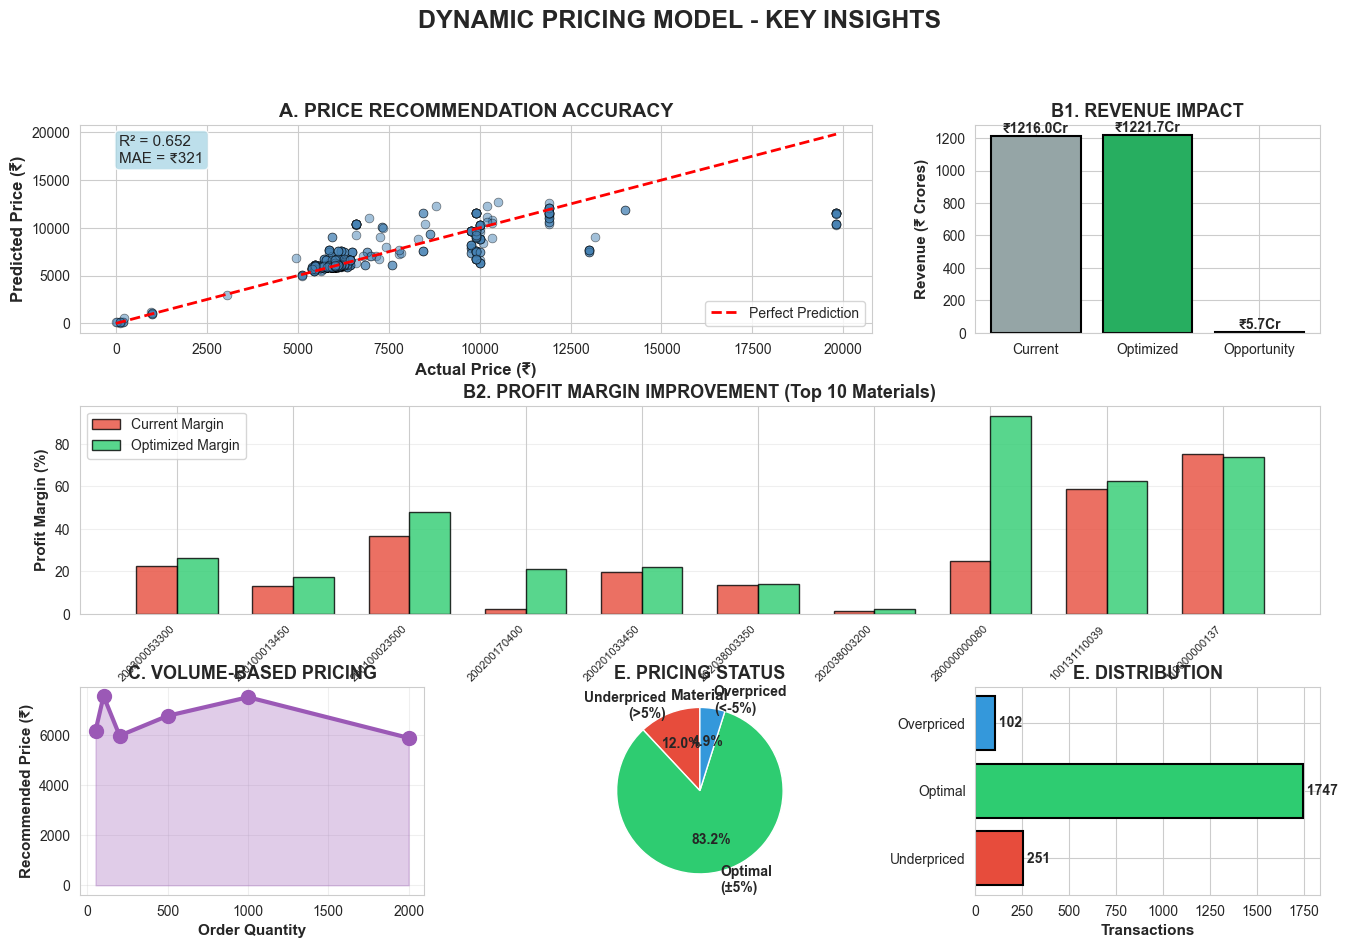


✓ Dashboard saved: dashboard.png


In [13]:
# === COMPLETE DASHBOARD VISUALIZATION ===
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style("whitegrid")

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# A. ACTUAL VS PREDICTED
ax1 = fig.add_subplot(gs[0, :2])
ax1.scatter(test['Unit_Price'], test['Predicted_Price'], alpha=0.5, s=40, c='steelblue', edgecolors='black', linewidth=0.5)
ax1.plot([0, test['Unit_Price'].max()], [0, test['Unit_Price'].max()], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Price (₹)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Predicted Price (₹)', fontsize=12, fontweight='bold')
ax1.set_title('A. PRICE RECOMMENDATION ACCURACY', fontsize=14, fontweight='bold')
ax1.legend()
ax1.text(0.05, 0.95, f'R² = {r2_score(y_test, test["Predicted_Price"]):.3f}\nMAE = ₹{mean_absolute_error(y_test, test["Predicted_Price"]):.0f}', 
         transform=ax1.transAxes, fontsize=11, verticalalignment='top', 
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

# B1. REVENUE IMPACT
ax2 = fig.add_subplot(gs[0, 2])
categories = ['Current', 'Optimized', 'Opportunity']
values = [current_revenue/1e7, optimized_revenue/1e7, opportunity/1e7]
colors_rev = ['#95a5a6', '#27ae60', '#f1c40f']
bars = ax2.bar(categories, values, color=colors_rev, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Revenue (₹ Crores)', fontsize=11, fontweight='bold')
ax2.set_title('B1. REVENUE IMPACT', fontsize=13, fontweight='bold')
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'₹{height:.1f}Cr', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# B2. MARGIN IMPROVEMENT
ax3 = fig.add_subplot(gs[1, :])
margin_comparison = test.groupby('Material_Clean').agg({
    'Current_Margin': 'mean',
    'Predicted_Margin': 'mean',
    'Revenue_Impact': 'sum'
}).sort_values('Revenue_Impact', ascending=False).head(10)

x = np.arange(len(margin_comparison))
width = 0.35
bars1 = ax3.bar(x - width/2, margin_comparison['Current_Margin'], width, 
                label='Current Margin', color='#e74c3c', alpha=0.8, edgecolor='black')
bars2 = ax3.bar(x + width/2, margin_comparison['Predicted_Margin'], width, 
                label='Optimized Margin', color='#2ecc71', alpha=0.8, edgecolor='black')

ax3.set_xlabel('Material', fontsize=11, fontweight='bold')
ax3.set_ylabel('Profit Margin (%)', fontsize=11, fontweight='bold')
ax3.set_title('B2. PROFIT MARGIN IMPROVEMENT (Top 10 Materials)', fontsize=13, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(margin_comparison.index, rotation=45, ha='right', fontsize=8)
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')

# C. VOLUME-BASED PRICING
ax4 = fig.add_subplot(gs[2, 0])
sample_mat = test['Material_Clean'].mode()[0]
sample_cost = test[test['Material_Clean']==sample_mat]['Unit_Cost'].mean()
quantities = [50, 100, 200, 500, 1000, 2000]
prices = []
for qty in quantities:
    mat_enc = material_price_map.get(sample_mat, train['Unit_Price'].mean())
    group = test[test['Material_Clean']==sample_mat]['Material Group'].iloc[0]
    group_enc = group_price_map.get(group, train['Unit_Price'].mean())
    input_data = pd.DataFrame([[mat_enc, group_enc, qty, sample_cost]], 
                              columns=['Material_Enc', 'Group_Enc', 'Order Quantity', 'Unit_Cost'])
    prices.append(model.predict(input_data)[0])

ax4.plot(quantities, prices, marker='o', linewidth=3, markersize=10, color='#9b59b6')
ax4.fill_between(quantities, prices, alpha=0.3, color='#9b59b6')
ax4.set_xlabel('Order Quantity', fontsize=11, fontweight='bold')
ax4.set_ylabel('Recommended Price (₹)', fontsize=11, fontweight='bold')
ax4.set_title('C. VOLUME-BASED PRICING', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3)

# E. PRICING STATUS (Pie)
ax5 = fig.add_subplot(gs[2, 1])
pricing_status = ['Underpriced\n(>5%)', 'Optimal\n(±5%)', 'Overpriced\n(<-5%)']
counts = [len(underpriced), len(test)-len(underpriced)-len(overpriced), len(overpriced)]
colors_pie = ['#e74c3c', '#2ecc71', '#3498db']
wedges, texts, autotexts = ax5.pie(counts, labels=pricing_status, autopct='%1.1f%%', 
                                     colors=colors_pie, startangle=90, 
                                     textprops={'fontsize': 10, 'fontweight': 'bold'})
ax5.set_title('E. PRICING STATUS', fontsize=13, fontweight='bold')

# E. PRICING STATUS (Bar)
ax6 = fig.add_subplot(gs[2, 2])
status_labels = ['Underpriced', 'Optimal', 'Overpriced']
ax6.barh(status_labels, counts, color=colors_pie, edgecolor='black', linewidth=1.5)
ax6.set_xlabel('Transactions', fontsize=11, fontweight='bold')
ax6.set_title('E. DISTRIBUTION', fontsize=13, fontweight='bold')
for i, v in enumerate(counts):
    ax6.text(v, i, f' {v}', va='center', fontsize=10, fontweight='bold')

plt.suptitle('DYNAMIC PRICING MODEL - KEY INSIGHTS', fontsize=18, fontweight='bold', y=0.995)
plt.savefig('../dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Dashboard saved: dashboard.png")
